In [1]:
# https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit

import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# criando dados
data = [[1.5, 74, 44.5, 26.7, 14.1], [2, 41.2, 23.7, 15, 7.3], 
        [3, 18.4, 10.5, 6.8, 3.7], [5, 6.8, 3.9, 2.2, 1.5]]
names = ['d/h', 30, 10, 4, 1]

# formatando dados
df = pd.DataFrame(data, columns = names)
df = df.set_index('d/h')
x_vals = df.index

In [2]:
# tabela contendo em d, valores de diâmtero(cm) para gargalo da garrafa, em h, altura(cm) da coluna d'água, 
# os valores que compõe a mesma consistem no tempo(s) de vazão da garrafa
df

,30,10,4,1
d/h,,,,
1.5,74.0,44.5,26.7,14.1
2.0,41.2,23.7,15.0,7.3
3.0,18.4,10.5,6.8,3.7
5.0,6.8,3.9,2.2,1.5


# Ajuste de função e predição de tempo de vazão para cada valor de d

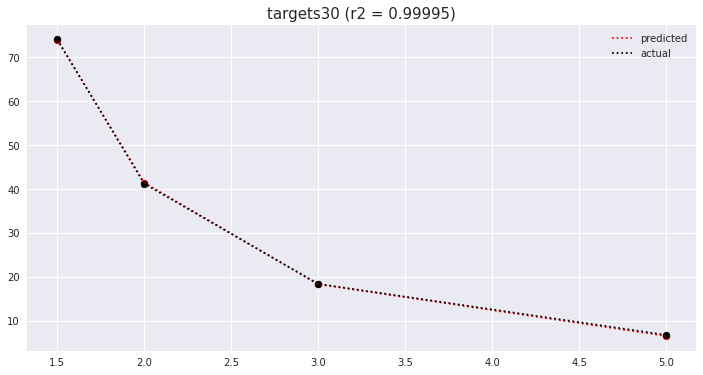

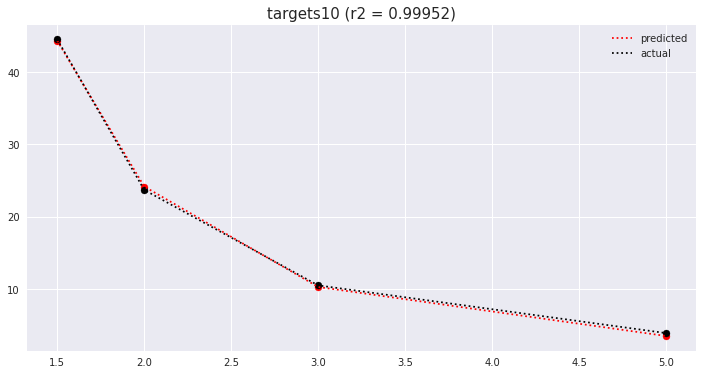

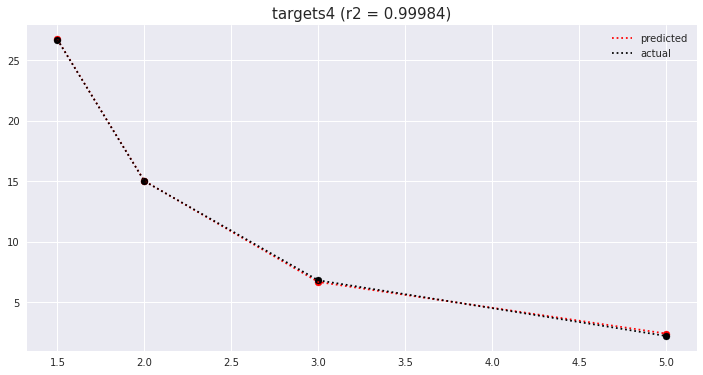

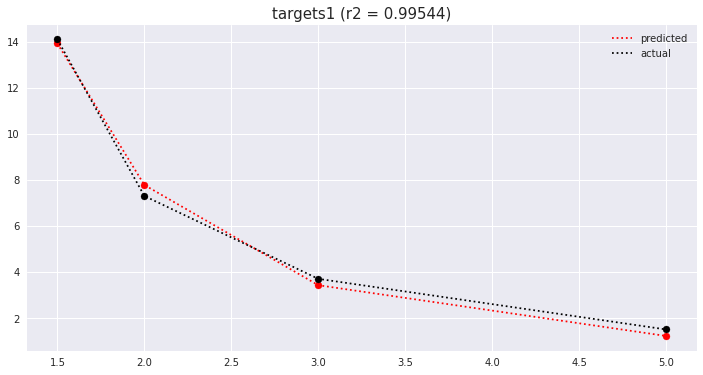

In [3]:
# delcarando função à qual os dados devem ser ajustados
def funcao(d, c, x):
    return c * (d ** (-x))

# obtendo coeficientes da função do ajuste, além dos valores observados e preditos do alvo 
# este laço traz em coef_list, uma lista de listas, onde cada sub lista contém, em ordem, os coeficientes
# c e d, para cada valor de h, 
# target_pred_dict passará a conter, para cada uma de suas chaves, uma lista, cujo primeiro elemento
# consiste nos tempos de vazão para cada diâmetro, para determinado h, observados, já o segundo elemento, 
# possui os valores preditos, de acordo com a função obtida para cada valor de h (30, 10, 4, 1)
target_pred_dict = {}
coef_list = []
for i in [30, 10, 4, 1]:
    exec(f'yData{i} = df[{i}]')
    exec(f'popt{i}, _ = curve_fit(funcao, x_vals, yData{i})')
    exec(f'preds{i} = [funcao(idx, popt{i}[0], popt{i}[1]) for idx in df.index]')
    exec(f'target_pred_dict["targets{i}"] = [yData{i}, preds{i}]')
    exec(f'coef_list.append(popt{i}.tolist())')

# erro mínimo quadrado de cada ajuste
# adicionamos o r2 para cada modelagem, em suas respectivas chaves(o dicionário possue uma chave para cada
# valor de h)
for i in ['30', '10', '4', '1']:
    exec(f'residuals = np.array(preds{i}) - np.array(yData{i}.tolist())')
    ss_res = np.sum(residuals ** 2)
    exec(f'ss_tot = np.sum((yData{i} - np.mean(yData{i}))**2)')
    exec(f'r_squared{i} = 1 - (ss_res / ss_tot)')
    
    exec(f"target_pred_dict['targets{i}'].append(r_squared{i})")

# função para o plot dos valores previstos contra observados, para cada h
def plot_curve_fit(x_vals, yData, preds, key, r2):
    
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (12, 6)
    
    plt.plot(x_vals, preds, label = 'predicted', ls = ':', color = 'red')
    plt.scatter(x_vals, preds, color = 'red')
    plt.plot(x_vals, yData, label = 'actual', ls = ':', color = 'black')
    plt.scatter(x_vals, yData, color = 'black')
    
    plt.title(f'{key} (r2 = {str(round(r2, 5))})', fontsize = 15)
    plt.legend()
    plt.show()

# laço que executa a função acima para os conjuntos de valores referentes a cada abertura (valor
# de cada series, 30, 10, 4, 1)

for key in target_pred_dict.keys():
    
    val = target_pred_dict[key]
    actual = val[0].tolist()
    preds = val[1]
    r2 = val[2]
    plot_curve_fit(x_vals, actual, preds, key, r2)
    
# abaixo, valores previstos e observados para cada abertura da garrafa

# Visualização consolidada de funções

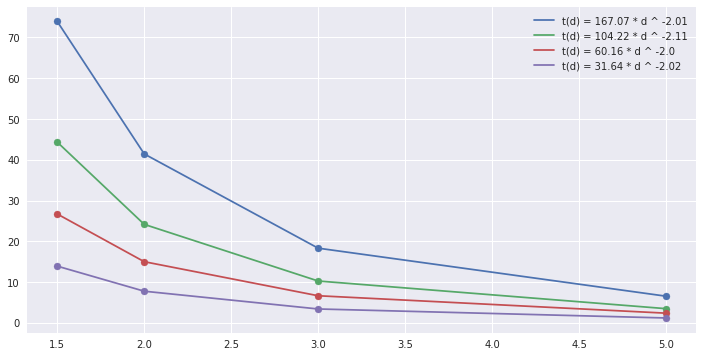

In [4]:
for i in [30, 10, 4, 1]:
    exec(f'c_coef = round(popt{i}[0], 2)')
    exec(f'd_coef = round(popt{i}[1], 2)')
    label = f't(d) = {c_coef} * d ^ -{d_coef}'
    exec(f'plt.plot(x_vals, preds{i}, label = "{label}")')
    exec(f'plt.scatter(x_vals, preds{i})')
    
plt.legend()
plt.show()

# plot dos valores previstos para cada abertura de garrafa, na legenda, as funções que formam cada linha

In [5]:
# dataframe com coeficientes de cada função, para cada h

coefs_df = pd.DataFrame(coef_list, columns = ['c', 'x'])
coefs_df['h'] = pd.Series([30, 10, 4, 1])
coefs_df = coefs_df.set_index('h')
coefs_df

,c,x
h,,
30,167.073501,2.011572
10,104.221310,2.108472
4,60.156841,2.002544
1,31.641778,2.024252


# Estimando coeficientes da função preditiva

In [6]:
# estimando valor de x, posto que se mantém num range estreito
np.median([i[1] for i in coef_list])

2.0179117259068673

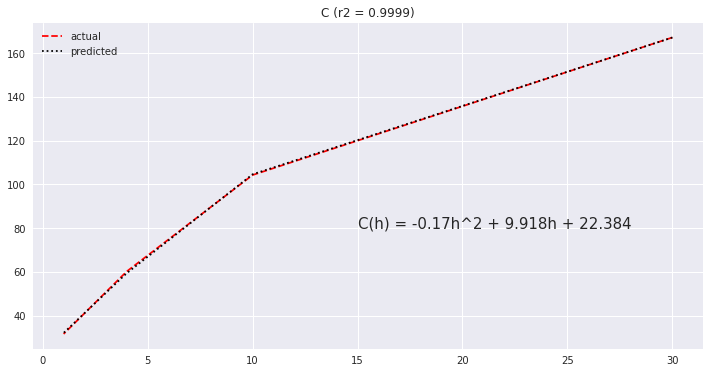

In [7]:
# função para modelar os coeficientes c
def func_coefs(x, a, b, c):
    return (a * (x ** 2)) + (b * x) + c

popt_coefs, _ = curve_fit(func_coefs, coefs_df.index, coefs_df.c) 
pred_c_coefs = [func_coefs(i, popt_coefs[0], popt_coefs[1], popt_coefs[2]) for i in coefs_df.index]

# erro mínimo na predição dos coeficientes de c
residuals = np.array(pred_c_coefs) - np.array(coefs_df.c.tolist())
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((coefs_df.c.tolist() - np.mean(coefs_df.c.tolist())) ** 2)
r2_c = 1 - (ss_res / ss_tot)

# plot da função que modela coeficiete c, contra os valores observados de c, em função de h

str_fn = f'C(h) = {round(popt_coefs[0], 3)}h^2 + {round(popt_coefs[1], 3)}h + {round(popt_coefs[2], 3)}'

plt.plot(coefs_df.index, coefs_df.c, color = 'red', label = 'actual', ls = '--')
plt.plot(coefs_df.index, pred_c_coefs, ls = ':', color = 'black', label = 'predicted')
plt.title(f'C (r2 = {round(r2_c, 5)})')
plt.text(s = str_fn, x = 15, y = 80, fontsize = 15)
plt.legend()
plt.show()

In [8]:
# reconstrução da tabela inicial, através das funções ajustadas

def pred_by_h(h, x, base_df):
    return [round(((-0.17*(h**2)) + 9.918*h + 22.384) * (d ** (-x)), 1) for d in base_df.index]

for i in [30, 10, 4, 1]:
    exec(f'series_h{i} = pd.Series(pred_by_h({i}, 2, df))')

tobe_idx = pd.Series([1.5, 2.0, 3.0, 5.0])

pred_df = pd.concat([series_h30, series_h10, series_h4, series_h1, tobe_idx], axis = 1) 
pred_df.columns = [30, 10, 4, 1, 'd/h']
pred_df = pred_df.set_index('d/h')

pred_df

,30,10,4,1
d/h,,,,
1.5,74.2,46.5,26.4,14.3
2.0,41.7,26.1,14.8,8.0
3.0,18.5,11.6,6.6,3.6
5.0,6.7,4.2,2.4,1.3


In [9]:
# tabela inicial
df

,30,10,4,1
d/h,,,,
1.5,74.0,44.5,26.7,14.1
2.0,41.2,23.7,15.0,7.3
3.0,18.4,10.5,6.8,3.7
5.0,6.8,3.9,2.2,1.5
